<a href="https://colab.research.google.com/github/niklasdonth/niklasdonth/blob/main/ml_for_wage_prediction_gesis_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("xtable","hdm","randomForest","gbm","rpart.plot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’, ‘glmnet’, ‘checkmate’, ‘Formula’




# Machine Learning Estimators for Wage Prediction

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have only used basic linear regression for estimation
Now, we also consider penalized regression models and nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [ ]:
load("/content/wage2015_subsample_inference.Rdata")
dim(data)

[1] 5150   20

The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [ ]:
Z <- subset(data,select=-c(lwage,wage)) # regressors
colnames(Z)

[1] "sex"  "shs"  "hsg"  "scl"  "clg"  "ad"   "mw"   "so"   "we"   "ne"  
[11] "exp1" "exp2" "exp3" "exp4" "occ"  "occ2" "ind"  "ind2"

The following figure shows the weekly wage distribution from the US survey data.

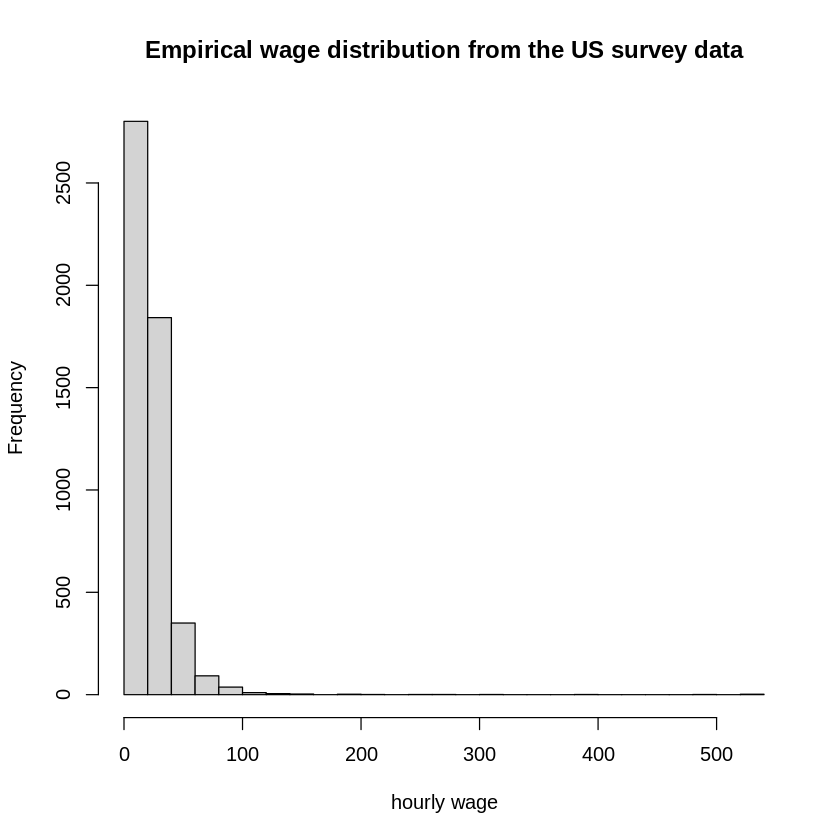

In [ ]:
hist(data$wage, xlab= "hourly wage", main="Empirical wage distribution from the US survey data", breaks= 35)

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [ ]:
set.seed(42)
training <- sample(nrow(data), nrow(data)*(3/4), replace=FALSE)

data_train <- data[training,]
data_test <- data[-training,]

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [ ]:
X_basic <-  "sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
X_flex <- "sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"
formula_basic <- as.formula(paste("lwage", "~", X_basic))
formula_flex <- as.formula(paste("lwage", "~", X_flex))

model_X_basic_train <- model.matrix(formula_basic,data_train)
model_X_basic_test <- model.matrix(formula_basic,data_test)
p_basic <- dim(model_X_basic_train)[2]
model_X_flex_train <- model.matrix(formula_flex,data_train)
model_X_flex_test <- model.matrix(formula_flex,data_test)
p_flex <- dim(model_X_flex_train)[2]

In [ ]:
Y_train <- data_train$lwage
Y_test <- data_test$lwage

In [ ]:
p_basic
p_flex

[1] 52

[1] 246

As known from our first lab, the basic model consists of about $50$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression.

### OLS

**Exercise 1:** Fit the basic and flexible model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [ ]:
# ols (basic model)
fit.lm.basic <- lm(formula_basic, data_train)

In [ ]:
# compute out-of-sample performance
yhat.lm.basic <- predict(fit.lm.basic, newdata=data_test)
cat("The mean squared error (MSE) using the basic model is equal to" , mean((Y_test-yhat.lm.basic)^2)) # MSE OLS (basic model)

The mean squared error (MSE) using the basic model is equal to 0.2162347

To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [ ]:
MSE.lm.basic <- summary(lm((Y_test-yhat.lm.basic)^2~1))$coef[1:2]
MSE.lm.basic

[1] 0.21623474 0.01466593

We also compute the out-of-sample $R^2$:

In [ ]:
R2.lm.basic <- 1-MSE.lm.basic[1]/var(Y_test)
cat("The R^2 using the basic model is equal to",R2.lm.basic) # MSE OLS (basic model)

The R^2 using the basic model is equal to 0.2875915

We repeat the same procedure for the flexible model.

In [ ]:
# ols (flexible model)
fit.lm.flex <- lm(formula_flex, data_train)
# Compute the Out-Of-Sample Performance
options(warn=-1)
yhat.lm.flex <- predict(fit.lm.flex, newdata=data_test)
MSE.lm.flex <- summary(lm((Y_test-yhat.lm.flex)^2~1))$coef[1:2]
R2.lm.flex <- 1-MSE.lm.flex[1]/var(Y_test)
cat("The R^2 using the flexible model is equal to",R2.lm.flex) # MSE OLS (flexible model)

The R^2 using the flexible model is equal to 0.2689486

We observe that ols regression works better for the basic model with smaller $p/n$ ratio.

We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


**Exercise 2:** Run a lasso/post-lasso regression first and then compute the measures for the out-of-sample performance. Apply the package *hdm* and the function *rlasso* to rely on a theory-based choice of the penalty level $\lambda$ in the lasso regression.

In [ ]:
# lasso and versions
library(hdm)
fit.rlasso  <- rlasso(formula_basic, data_train, post=FALSE)
fit.rlasso.post <- rlasso(formula_basic, data_train, post=TRUE)
yhat.rlasso   <- predict(fit.rlasso, newdata=data_test)
yhat.rlasso.post   <- predict(fit.rlasso.post, newdata=data_test)

MSE.lasso <- summary(lm((Y_test-yhat.rlasso)^2~1))$coef[1:2]
MSE.lasso.post <- summary(lm((Y_test-yhat.rlasso.post)^2~1))$coef[1:2]

R2.lasso <- 1-MSE.lasso[1]/var(Y_test)
R2.lasso.post <- 1-MSE.lasso.post[1]/var(Y_test)
cat("The R^2 using the basic model is equal to",R2.lasso,"for lasso and",R2.lasso.post,"for post-lasso") # R^2 lasso/post-lasso (basic model)

The R^2 using the basic model is equal to 0.2674882 for lasso and 0.2677112 for post-lasso

Now, we repeat the same procedure for the flexible model.

In [ ]:
fit.rlasso.flex  <- rlasso(formula_flex, data_train, post=FALSE)
fit.rlasso.post.flex <- rlasso(formula_flex, data_train, post=TRUE)
yhat.rlasso.flex   <- predict(fit.rlasso.flex, newdata=data_test)
yhat.rlasso.post.flex   <- predict(fit.rlasso.post.flex, newdata=data_test)

MSE.lasso.flex <- summary(lm((Y_test-yhat.rlasso.flex)^2~1))$coef[1:2]
MSE.lasso.post.flex <- summary(lm((Y_test-yhat.rlasso.post.flex)^2~1))$coef[1:2]

R2.lasso.flex <- 1-MSE.lasso.flex[1]/var(Y_test)
R2.lasso.post.flex <- 1-MSE.lasso.post.flex[1]/var(Y_test)
cat("The R^2 using the flexible model is equal to",R2.lasso.flex,"for lasso and",R2.lasso.post.flex,"for post-lasso") # R^2 lasso/post-lasso (flexible model)

The R^2 using the flexible model is equal to 0.2661038 for lasso and 0.2526069 for post-lasso

The lasso regression works not better for the more complex model.

In contrast to a theory-based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet.

**Exercise 3:** In this context, run a lasso, a ridge and a elastic net regression by adjusting the parameter *alpha* in the function *cv.glmnet*. Which model has the lowest mean squared error on the test sample?

In [ ]:
library(glmnet)
fit.lasso.cv   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=1)
fit.ridge   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=0)
fit.elnet   <- cv.glmnet(model_X_basic_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = model_X_basic_test)
yhat.ridge   <- predict(fit.ridge, newx = model_X_basic_test)
yhat.elnet   <- predict(fit.elnet, newx = model_X_basic_test)

MSE.lasso.cv <- summary(lm((Y_test-yhat.lasso.cv)^2~1))$coef[1:2]
MSE.ridge <- summary(lm((Y_test-yhat.ridge)^2~1))$coef[1:2]
MSE.elnet <- summary(lm((Y_test-yhat.elnet)^2~1))$coef[1:2]

R2.lasso.cv <- 1-MSE.lasso.cv[1]/var(Y_test)
R2.ridge <- 1-MSE.ridge[1]/var(Y_test)
R2.elnet <- 1-MSE.elnet[1]/var(Y_test)

# R^2 using cross-validation (basic model)
cat("R^2 using cross-validation for lasso, ridge and elastic net in the basic model:",R2.lasso.cv,R2.ridge,R2.elnet)

Loading required package: Matrix

Loaded glmnet 4.1-8



R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.2811662 0.2576451 0.2760405

In [ ]:
fit.lasso.cv.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=1)
fit.ridge.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=0)
fit.elnet.flex   <- cv.glmnet(model_X_flex_train, Y_train, family="gaussian", alpha=.5)

yhat.lasso.cv.flex    <- predict(fit.lasso.cv.flex , newx = model_X_flex_test)
yhat.ridge.flex    <- predict(fit.ridge.flex , newx = model_X_flex_test)
yhat.elnet.flex    <- predict(fit.elnet.flex , newx = model_X_flex_test)

MSE.lasso.cv.flex  <- summary(lm((Y_test-yhat.lasso.cv.flex )^2~1))$coef[1:2]
MSE.ridge.flex  <- summary(lm((Y_test-yhat.ridge.flex )^2~1))$coef[1:2]
MSE.elnet.flex  <- summary(lm((Y_test-yhat.elnet.flex )^2~1))$coef[1:2]

R2.lasso.cv.flex  <- 1-MSE.lasso.cv.flex [1]/var(Y_test)
R2.ridge.flex  <- 1-MSE.ridge.flex [1]/var(Y_test)
R2.elnet.flex  <- 1-MSE.elnet.flex [1]/var(Y_test)

# R^2 using cross-validation (flexible model)
cat("R^2 using cross-validation for lasso, ridge and elastic net in the flexible model:",R2.lasso.cv.flex,R2.ridge.flex,R2.elnet.flex)

R^2 using cross-validation for lasso, ridge and elastic net in the flexible model: 0.2704411 0.2451732 0.2754132

The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are apply regression trees, random forests and boosted trees to estimate the regression function $g(X)$. First, we load the relevant libraries.

In [ ]:
library(randomForest)
library(rpart)
#library(nnet)
library(gbm)
library(rpart.plot)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.9

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The parameter *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

**Exercise 4:** Play around with the tuning parameter *cp* and check how the structur of the regression tree changes. What does the parameter *cp* control?

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


cex 0.15   xlim c(0, 1)   ylim c(0, 1)


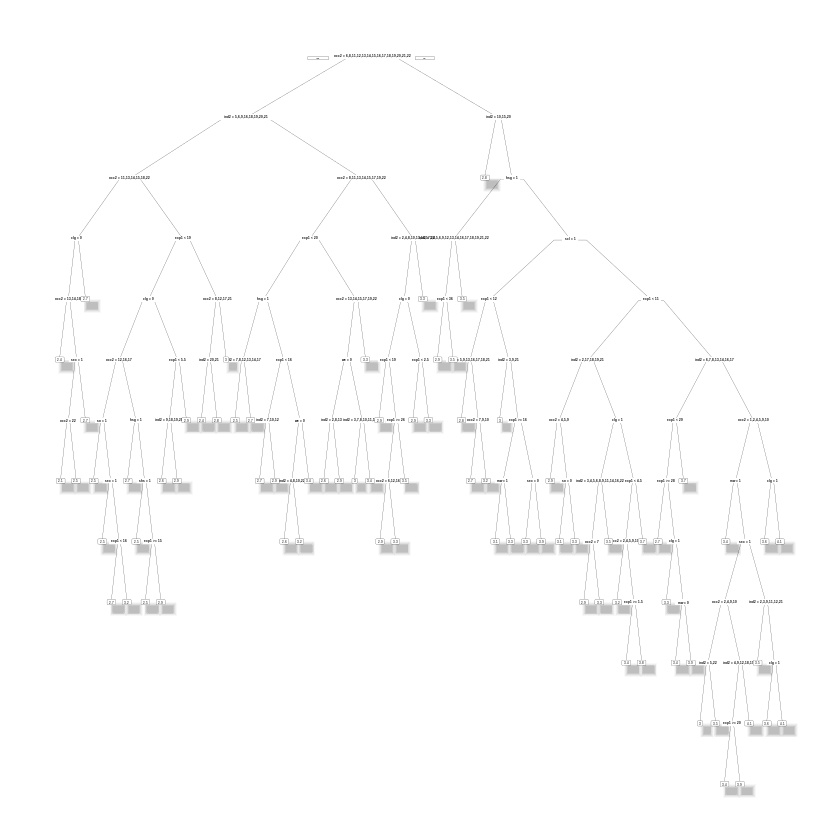

In [ ]:
# fit the tree
fit.trees <- rpart(formula_basic, data_train,cp = 0.001)
prp(fit.trees,leaf.round=1, space=2, yspace=2,split.space=2,shadow.col = "gray",trace = 1) # plotting the tree

In [ ]:
?rpart.control

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

In [ ]:
bestcp<- fit.trees$cptable[which.min(fit.trees$cptable[,"xerror"]),"CP"]
bestcp

[1] 0.001694692

Now, we can prune the tree and visualize the prediction rule.

cex 0.363   xlim c(0, 1)   ylim c(0, 1)


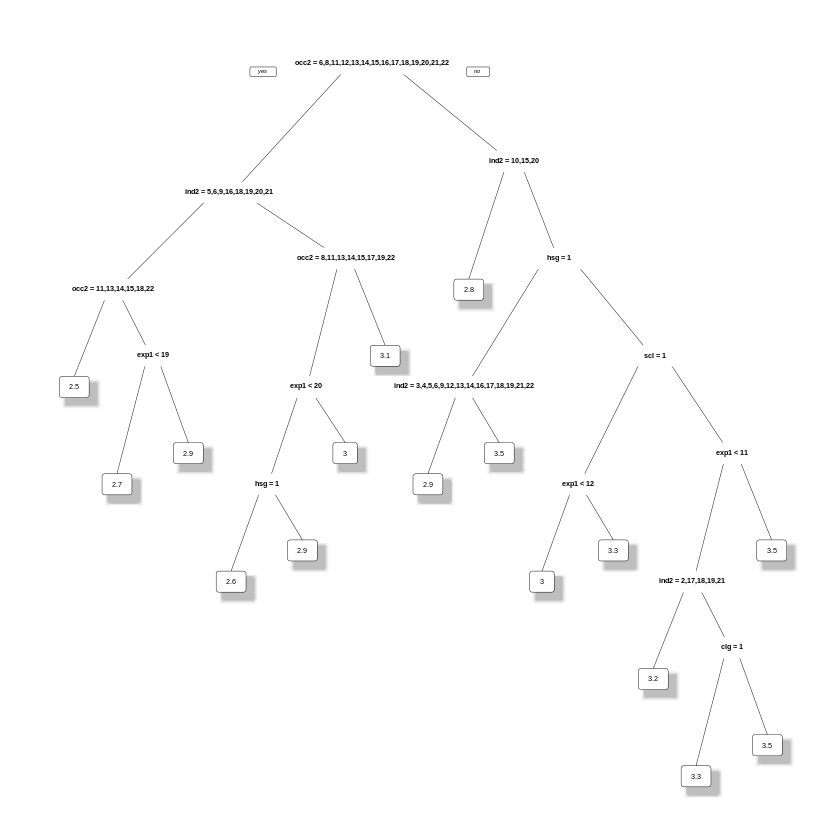

In [ ]:
fit.prunedtree <- prune(fit.trees,cp=bestcp)
prp(fit.prunedtree,leaf.round=1, space=3, yspace=3, split.space=7, shadow.col = "gray",trace = 1,yesno=1)

**Exercise 5:** Finally, calculate the mean-squared error  on the test sample to evaluate the out-of-sample performance of the pruned tree.

In [ ]:
yhat.pt <- predict(fit.prunedtree,newdata=data_test)
MSE.pt <- summary(lm((Y_test-yhat.pt)^2~1))$coef[1:2]
R2.pt  <- 1-MSE.pt[1]/var(Y_test)

# R^2 of the pruned tree
cat("R^2 of the pruned tree:",R2.pt)
MSE.pt[1]

R^2 of the pruned tree: 0.2066446

[1] 0.2408042

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods: random forest and boosted trees.

In [ ]:
## Applying the methods
# random forest
fit.rf       <- randomForest(formula_basic, ntree=2000, nodesize=5, data=data_train)
# for tuning: adjust input "mtry" to change the number of variables randomly sampled as candidates at each split

# boosting
fit.boost   <- gbm(formula_basic, data=data_train, distribution= "gaussian", bag.fraction = .5, interaction.depth=2, n.trees=1000, shrinkage=.01)
best.boost  <- gbm.perf(fit.boost, plot.it = FALSE) # cross-validation to determine when to stop

## Evaluating the methods
yhat.rf       <- predict(fit.rf, newdata=data_test) # prediction
yhat.boost    <- predict(fit.boost, newdata=data_test, n.trees=best.boost)

MSE.rf       = summary(lm((Y_test-yhat.rf)^2~1))$coef[1:2]
MSE.boost    = summary(lm((Y_test-yhat.boost)^2~1))$coef[1:2]
R2.rf  <- 1-MSE.rf[1]/var(Y_test)
R2.boost  <- 1-MSE.boost[1]/var(Y_test)

# printing R^2
cat("R^2 of the random forest and boosted trees:",R2.rf,R2.boost)


**Exercise 6:** To conclude, summarize the results. What is the best model?

## Results

In [ ]:
library(xtable)
table<- matrix(0, 15, 3)
table[1,1:2]   <- MSE.lm.basic
table[2,1:2]   <- MSE.lm.flex
table[3,1:2]   <- MSE.lasso
table[4,1:2]   <- MSE.lasso.post
table[5,1:2]   <- MSE.lasso.flex
table[6,1:2]   <- MSE.lasso.post.flex
table[7,1:2]   <- MSE.lasso.cv
table[8,1:2]   <- MSE.ridge
table[9,1:2]   <- MSE.elnet
table[10,1:2]   <- MSE.lasso.cv.flex
table[11,1:2]  <- MSE.ridge.flex
table[12,1:2]  <- MSE.elnet.flex
table[13,1:2]  <- MSE.rf
table[14,1:2]  <- MSE.boost
table[15,1:2]  <- MSE.pt

table[1,3]   <- R2.lm.basic
table[2,3]   <- R2.lm.flex
table[3,3]   <- R2.lasso
table[4,3]   <- R2.lasso.post
table[5,3]   <- R2.lasso.flex
table[6,3]   <- R2.lasso.post.flex
table[7,3]   <- R2.lasso.cv
table[8,3]   <- R2.ridge
table[9,3]   <- R2.elnet
table[10,3]   <- R2.lasso.cv.flex
table[11,3]  <- R2.ridge.flex
table[12,3]  <- R2.elnet.flex
table[13,3]  <- R2.rf
table[14,3]  <- R2.boost
table[15,3]  <- R2.pt

colnames(table)<- c("MSE", "S.E. for MSE", "R-squared")
rownames(table)<- c("Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)",
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",
                    "Random Forest","Boosted Trees", "Pruned Tree")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab

Above, we have displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$ in column 3.

Given our sample split, we see that the prediction rules produced by ols using the basic model, cross-Validated Lasso using the flexible model and the Random Forest perform very well. For many of our methods, the testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest.Notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

### Ensemble learning

**Exercise 7:** In the final step, build a prediction model by combining the strengths of the models we considered so far. This ensemble method is of the form
	$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest and Boosted Trees and combine these methods into an ensemble method. The appropriate weights can be determined by a simple ols regression:

In [ ]:
ensemble.ols <- summary(lm(Y_test~ yhat.lm.basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.ols


Call:
lm(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1647 -0.2771 -0.0121  0.2628  3.3150 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.28181    0.18737   1.504 0.132814    
yhat.lm.basic          0.58169    0.16078   3.618 0.000309 ***
yhat.rlasso.post.flex  0.12772    0.18110   0.705 0.480782    
yhat.elnet.flex       -0.18590    0.28438  -0.654 0.513416    
yhat.pt               -0.10601    0.10012  -1.059 0.289900    
yhat.rf                0.60379    0.08859   6.816 1.44e-11 ***
yhat.boost            -0.11161    0.18499  -0.603 0.546397    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4562 on 1281 degrees of freedom
Multiple R-squared:  0.3176,	Adjusted R-squared:  0.3144 
F-statistic: 99.37 on 6 and 1281 DF,  p-value: < 2.2e-16


Alternatively, we can determine the weights via lasso regression.

In [ ]:
ensemble.lasso <- summary(rlasso(Y_test~ yhat.lm.basic + yhat.rlasso.post.flex + yhat.elnet.flex+ yhat.pt+ yhat.rf + yhat.boost))
ensemble.lasso


Call:
rlasso.formula(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Post-Lasso Estimation:  TRUE 

Total number of variables: 6
Number of selected variables: 2 

Residuals: 
     Min       1Q   Median       3Q      Max 
-2.17472 -0.27738 -0.01574  0.26031  3.31338 

                      Estimate
(Intercept)              0.100
yhat.lm.basic            0.427
yhat.rlasso.post.flex    0.000
yhat.elnet.flex          0.000
yhat.pt                  0.000
yhat.rf                  0.544
yhat.boost               0.000

Residual standard error: 0.4558
Multiple R-squared:  0.3156
Adjusted R-squared:  0.3145
Joint significance test:
 the sup score statistic for joint significance test is 3.578 with a p-value of  0.04



Call:
rlasso.formula(formula = Y_test ~ yhat.lm.basic + yhat.rlasso.post.flex + 
    yhat.elnet.flex + yhat.pt + yhat.rf + yhat.boost)

Coefficients:
          (Intercept)          yhat.lm.basic  yhat.rlasso.post.flex  
               0.1003                 0.4272                 0.0000  
      yhat.elnet.flex                yhat.pt                yhat.rf  
               0.0000                 0.0000                 0.5439  
           yhat.boost  
               0.0000  


The estimated weights are shown in the following table.

In [ ]:
table<- matrix(0, 7, 2)
table[1:7,1]   <- ensemble.ols$coef[1:7]
table[1:7,2]   <- ensemble.lasso$coef[1:7]

colnames(table)<- c("Weight OLS", "Weight Lasso")
rownames(table)<- c("Constant","Least Squares (basic)","Post-Lasso (flexible)", "Cross-Validated elnet (flexible)", "Pruned Tree",
                    "Random Forest","Boosted Trees")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab

% latex table generated in R 4.3.0 by xtable 1.8-4 package
% Thu Jun 22 14:05:09 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Weight OLS & Weight Lasso \\ 
  \hline
Constant & 0.282 & 0.100 \\ 
  Least Squares (basic) & 0.582 & 0.427 \\ 
  Post-Lasso (flexible) & 0.128 & 0.000 \\ 
  Cross-Validated elnet (flexible) & -0.186 & 0.000 \\ 
  Pruned Tree & -0.106 & 0.000 \\ 
  Random Forest & 0.604 & 0.544 \\ 
  Boosted Trees & -0.112 & 0.000 \\ 
   \hline
\end{tabular}
\end{table}


,Weight OLS,Weight Lasso
,<dbl>,<dbl>
Constant,0.2818140,0.1002651
Least Squares (basic),0.5816943,0.4272396
Post-Lasso (flexible),0.1277236,0.0000000
Cross-Validated elnet (flexible),-0.1859003,0.0000000
Pruned Tree,-0.1060081,0.0000000
Random Forest,0.6037916,0.5438718
Boosted Trees,-0.1116096,0.0000000


Further, the $R^2$ for the test sample improves from  to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth noticing that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.